In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import seaborn as sns # visualization
import math
import squarify  # (algorithm for treemap)
import folium # map
from IPython.display import display_html 

In [2]:
# Reading Csv file
df = pd.read_csv('/kaggle/input/fatal-police-shootings-in-the-us/PoliceKillingsUS.csv', encoding='cp1252')
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


# Information about the dataset

In [3]:
def information(dataframe):
    print('Shape\n')
    print(pd.DataFrame({'Row Count': [dataframe.shape[0]],
                        'Column Count': [dataframe.shape[1]]
                       },index=['']
                      )
         )
    print('----------------------------------------------\n')
    print('General Info\n')
    print(df.info())
    print('----------------------------------------------\n')
    print('Missing Values\n')
    print(df.isna().sum())
        
information(df)    

Shape

  Row Count  Column Count
       2535            14
----------------------------------------------

General Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2535 non-null   int64  
 1   name                     2535 non-null   object 
 2   date                     2535 non-null   object 
 3   manner_of_death          2535 non-null   object 
 4   armed                    2526 non-null   object 
 5   age                      2458 non-null   float64
 6   gender                   2535 non-null   object 
 7   race                     2340 non-null   object 
 8   city                     2535 non-null   object 
 9   state                    2535 non-null   object 
 10  signs_of_mental_illness  2535 non-null   bool   
 11  threat_level             2535 non-null   object 
 12  flee       

# Categorical and Numerical Variables

In [4]:
def col_summary(dataframe, cat_th=13, car_th=20):
    categorical_cols= [col for col in df.columns if str(df[col].dtypes) in ["category","object", "bool"]]
    numerical_but_categorical_cols=[col for col in df.columns if df[col].nunique()<10 and df[col].dtypes in ["int", "float"]]
    categorical_but_cardinal_cols= [col for col in df.columns if df[col].nunique()>20 and str(df[col].dtypes) in ["category", "object"]]
    categorical_cols= categorical_cols + numerical_but_categorical_cols
    categorical_cols = [col for col in categorical_cols if col not in categorical_but_cardinal_cols]

    numerical_cols= [col for col in df.columns if df[col].dtypes in ["int", "float"]]
    numerical_cols= [col for col in numerical_cols if col not in categorical_cols]

    
    print(f"Categorical_cols: {categorical_cols}")
    print(f"Numerical_cols: {numerical_cols}")
    print(f"Categorical_but_cardinal_cols: {categorical_but_cardinal_cols}")
    print(f"Numerical_but_categorical_cols: {numerical_but_categorical_cols}")

    return categorical_cols, numerical_cols,categorical_but_cardinal_cols, numerical_but_categorical_cols

categorical_cols, numerical_cols, categorical_but_cardinal_cols, numerical_but_categorical_cols= col_summary(df)

Categorical_cols: ['manner_of_death', 'gender', 'race', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera']
Numerical_cols: ['id', 'age']
Categorical_but_cardinal_cols: ['name', 'date', 'armed', 'city', 'state']
Numerical_but_categorical_cols: []


 # Data Cleaning

In [5]:
# Fill null age values with mean
df.age.fillna(int(df.age.mean()), inplace=True)

# Fill null values with 'unknown'
def fill_null_values(dataframe, columns, default='unknown'):
    [dataframe[col].fillna(default, inplace=True) for col in columns]
    
    
fill_null_values(df, ['race', 'armed', 'flee'])    

In [6]:
# Let's check if there is any null value
df.isna().sum()

id                         0
name                       0
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
state                      0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
dtype: int64

<font size="4">Type Changes</font>

In [7]:
# Convert float to integer
df['age'] = df['age'].astype(int)

# Convert object to datetime
df['date'] = pd.to_datetime(df['date'])

# Seperating month, year and week days
df['day_of_week'] = df['date'].dt.strftime('%A')
df['month'] = df['date'].dt.strftime('%B')
df['year'] = df['date'].dt.year

In [8]:
# Changing abbreviated city states to full form
state_dict = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
              'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 
              'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 
              'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 
              'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 
              'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 
              'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 
              'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 
              'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 
              'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'}

df['state'] = df['state'].map(state_dict)

In [9]:
# Capitalizing column names
df.columns = df.columns.str.capitalize()

# Capitalizing not numeric values
l = df.columns.values.tolist()

for i in l:
    if df[i].dtype in ['object']:
        df[i] = df[i].str.capitalize()

In [10]:
# Drop useless columns
df.drop(['Id', 'Date'], axis=1, inplace=True)

In [11]:
# Converting M to Male, F to Female in Gender column
df['Gender'] = np.where(df['Gender'] == 'M', 'Male', 'Female')

In [12]:
# Replacing some of race abbreviations to full form
race_mapping = {'W': 'White', 'B': 'Black', 'H': 'Hispanic', 'A': 'Asian', 'N': 'Native American', 'O': 'Other'}

df['Race'] = df['Race'].replace(race_mapping)

In [13]:
# Converting boolean values to Yes, No
def replace_boolean_values(dataframe, columns):
    for col in columns:
        dataframe[col] = np.where(dataframe[col] == True, 'Yes', 'No')
        
replace_boolean_values(df, ['Signs_of_mental_illness', 'Body_camera'])        

In [14]:
# Reordering columns
cols = df.columns.tolist()

cols = ['Gender', 'Race', 'Age'] + [col for col in cols if col not in ['Gender', 'Race', 'Age']]

df = df[cols]

In [15]:
df.head(3)

,Gender,Race,Age,Name,Manner_of_death,Armed,City,State,Signs_of_mental_illness,Threat_level,Flee,Body_camera,Day_of_week,Month,Year
0,Male,Asian,53,Tim elliot,Shot,Gun,Shelton,Washington,Yes,Attack,Not fleeing,No,Sunday,February,2015
1,Male,White,47,Lewis lee lembke,Shot,Gun,Aloha,Oregon,No,Attack,Not fleeing,No,Sunday,February,2015
2,Male,Hispanic,23,John paul quintero,Shot and tasered,Unarmed,Wichita,Kansas,No,Other,Not fleeing,No,Sunday,March,2015


In [16]:
# Descriptive statistics
df.describe().drop('count').T.round(1)

,mean,std,min,25%,50%,75%,max
Age,36.6,12.8,6.0,27.0,35.0,45.0,91.0
Year,2015.8,0.8,2015.0,2015.0,2016.0,2016.0,2017.0


# Visualization

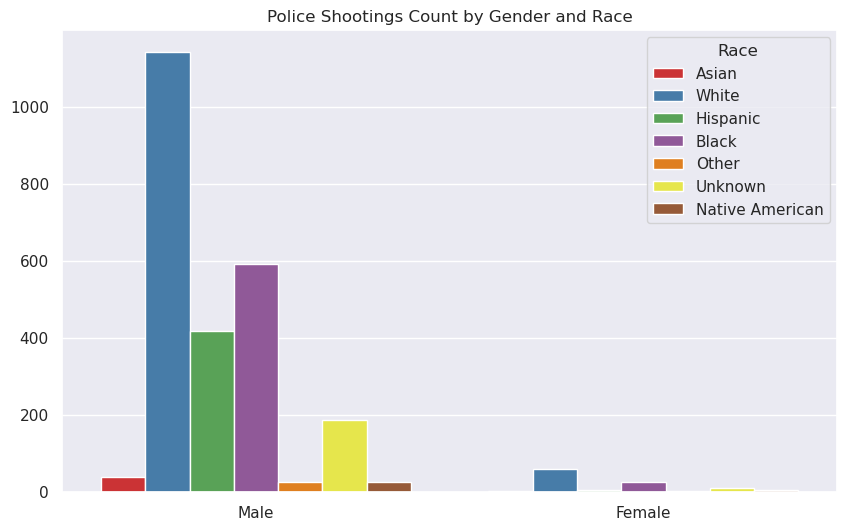

In [17]:
# Police Shootings Count by Gender and Race
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
sns.countplot(x="Gender", hue="Race", data=df, palette="Set1")
plt.title("Police Shootings Count by Gender and Race")
plt.xlabel(None)
plt.ylabel(None)
plt.show(block=True)

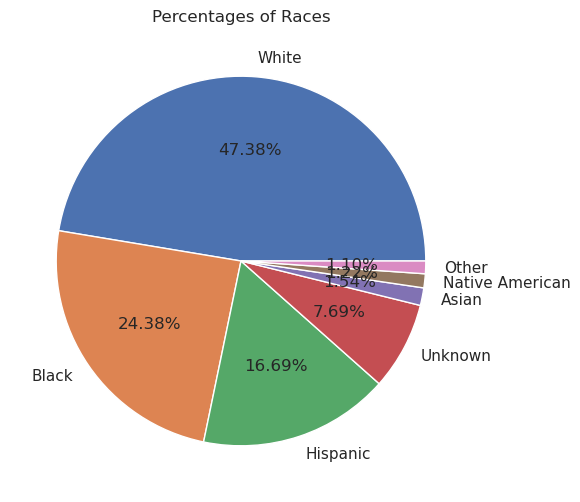

In [18]:
# Value counts percentages of races in pie plot
plt.figure(figsize=(10,6))
label = ['White', 'Black', 'Hispanic', 'Unknown', 'Asian', 'Native American', 'Other']
plt.pie(df['Race'].value_counts(), labels=label,autopct='%1.2f%%')
plt.title("Percentages of Races")
plt.show(block=True)

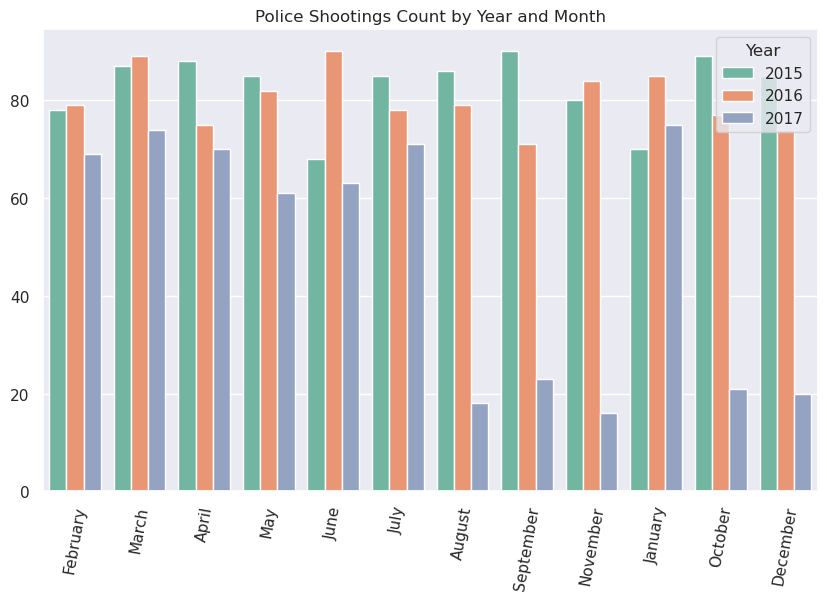

In [19]:
# Police Shootings Count by Year and Month
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
sns.countplot(x="Month", hue="Year", data=df, palette="Set2")
plt.title("Police Shootings Count by Year and Month")
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(rotation=80)
plt.show(block=True)

In [20]:
# Converting object values to num
to_num = {'Asian': 1, 'White': 2, 'Hispanic': 3, 'Black': 4, 'Other': 5, 'Unknown': 6, 'Native American': 7}
df['RaceNum'] = df['Race'].map(to_num)

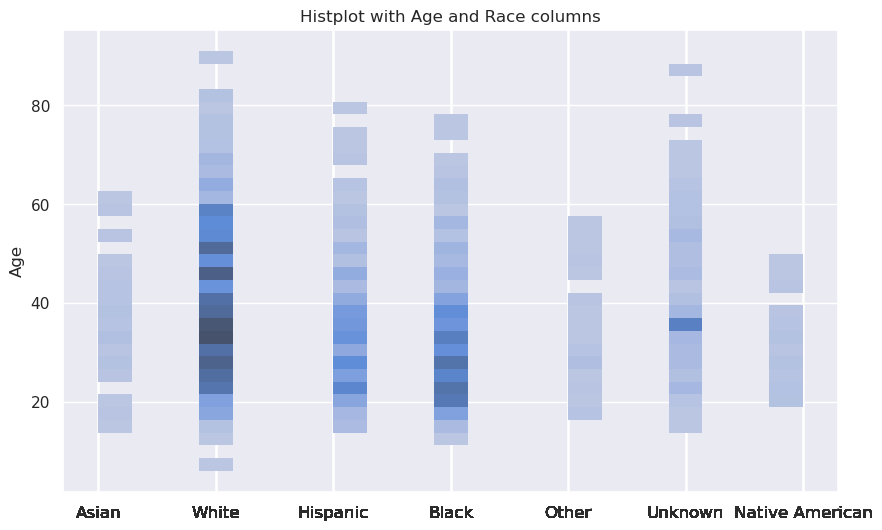

In [21]:
# Histogram plot
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
sns.histplot(x="RaceNum", y="Age", data=df)
plt.title("Histplot with Age and Race columns")

x_labels = {1: 'Asian', 2: 'White', 3: 'Hispanic', 4: 'Black', 5: 'Other', 6: 'Unknown', 7: 'Native American'}
plt.xticks(ticks=df["RaceNum"], labels=[x_labels[val] for val in df["RaceNum"]], color='#2C2C2C', fontsize='12')

plt.xlabel(None)
plt.ylabel('Age')
plt.show(block=True)

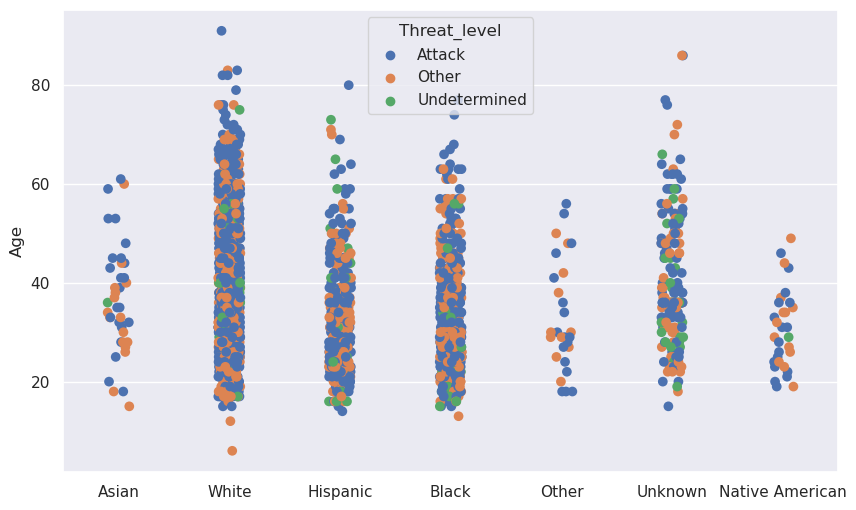

In [22]:
# See if there is any effect of age and race on threat level.
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
sns.stripplot(x="Race", y="Age",hue="Threat_level", size=7, data=df)
plt.xlabel(None)
plt.show()

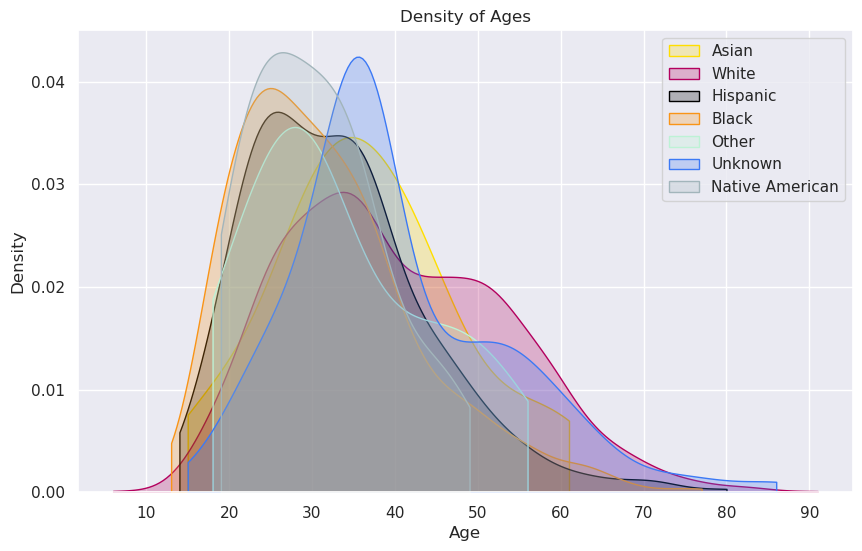

In [23]:
# Density of ages using kdeplot
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.xaxis.set_ticks(np.arange(0,100,10))

sns.kdeplot(df[df.Race == 'Asian'].Age, fill=True, ax=axes, color='#FFDE00', cut=0)
sns.kdeplot(df[df.Race == 'White'].Age, ax=axes, fill=True, color='#B3005E', cut=0)
sns.kdeplot(df[df.Race == 'Hispanic'].Age, ax=axes, fill=True, color='#000000', cut=0)
sns.kdeplot(df[df.Race == 'Black'].Age, ax=axes, fill=True, color='#F99417', cut=0)
sns.kdeplot(df[df.Race == 'Other'].Age, ax=axes, fill=True, color='#BDF2D5', cut=0)
sns.kdeplot(df[df.Race == 'Unknown'].Age, ax=axes, fill=True, color='#3C79F5', cut=0)
sns.kdeplot(df[df.Race == 'Native American'].Age, ax=axes, fill=True, color='#A2B5BB', cut=0)
plt.legend(['Asian', 'White', 'Hispanic', 'Black', 'Other', 'Unknown', 'Native American'])
plt.title("Density of Ages")
plt.show(block=True)

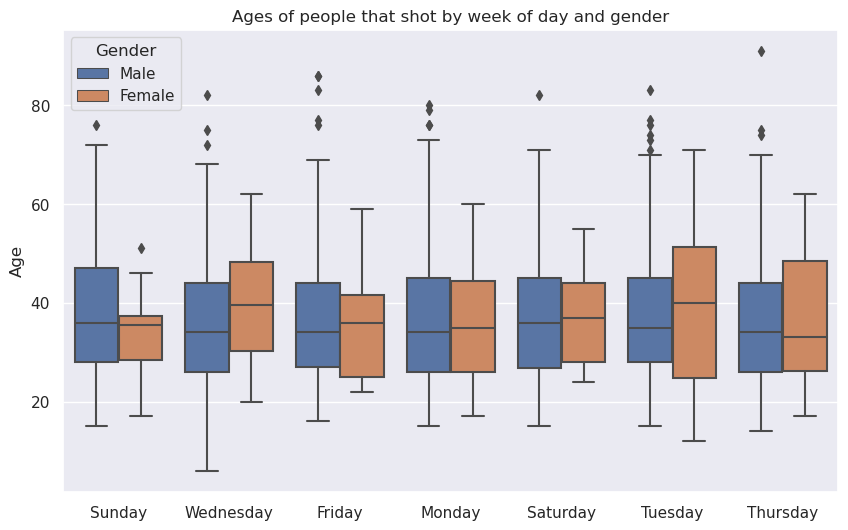

In [24]:
# This plot shows ages of people shot in week days.
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
plt.title("Ages of people that shot by week of day and gender")
sns.boxplot(x=df['Day_of_week'], y=df['Age'], hue=df['Gender'])
plt.xlabel(None)
plt.show(block=True)

<font size="4">Countplots of Signs of mental illness, Threat level, Body camera, Manner of death, Armed.</font>

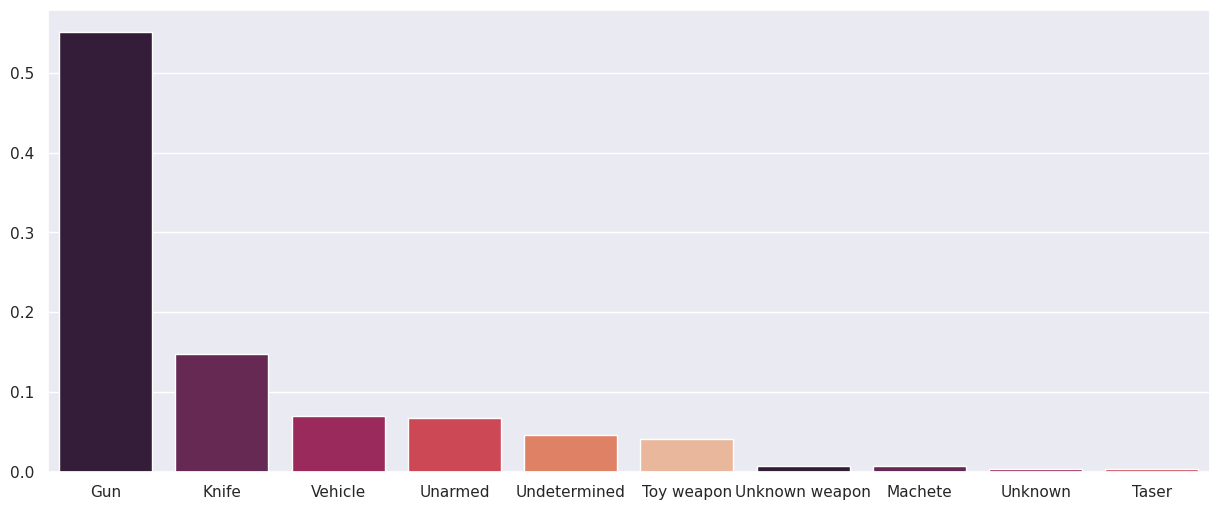

In [25]:
# Most common way of being armed
most_common_armed = df['Armed'].value_counts(normalize=True).iloc[0:10]

plt.figure(figsize=(15,6))
sns.set(style="darkgrid")
sns.barplot(x=most_common_armed.index, y=most_common_armed.values, palette=sns.color_palette("rocket"))
plt.show(block=True)

In [26]:
# Value Counts
b1 = df['Signs_of_mental_illness'].value_counts(normalize=True)
b2 = df['Threat_level'].value_counts(normalize=True)
b3 = df['Body_camera'].value_counts(normalize=True)
b4 = df['Manner_of_death'].value_counts(normalize=True)

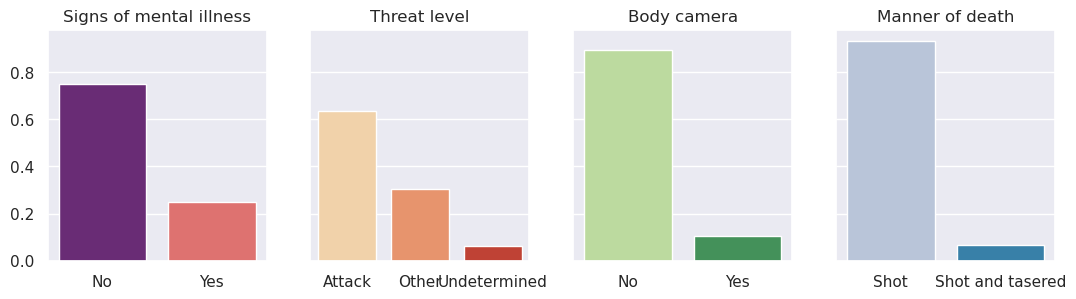

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(13, 3), sharey=True)
sns.set(style="darkgrid")
sns.barplot(x=b1.index, y=b1.values, palette="magma", ax=axes[0])
axes[0].set_title('Signs of mental illness')
sns.barplot(x=b2.index, y=b2.values, palette="OrRd", ax=axes[1])
axes[1].set_title('Threat level')
sns.barplot(x=b3.index, y=b3.values, palette="YlGn", ax=axes[2])
axes[2].set_title('Body camera')
sns.barplot(x=b4.index, y=b4.values, palette="PuBu", ax=axes[3])
axes[3].set_title('Manner of death');

# Observations
1. %75 of the victims don't have any signs of mental illness.
2. %60 of the cases happened because there is an attack.
3. In %85 of the cases police didn't have a body camera.
4. And almost all of the death happened by shootingCities with the highest cases
5. Most common way of being armed is gun

<font size="4">Cities with the highest cases</font>

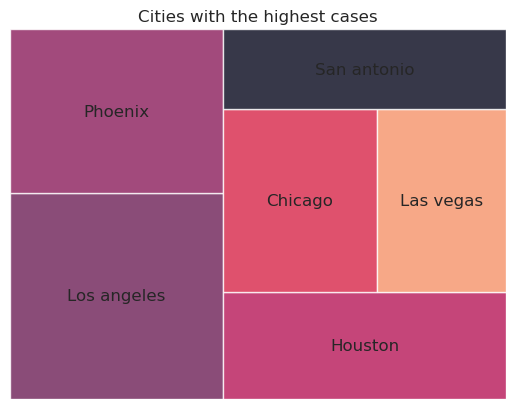

In [28]:
city_count = df['City'].value_counts().iloc[0:6]

squarify.plot(sizes=city_count.values, label=city_count.index, alpha=.8 )
plt.title('Cities with the highest cases')
plt.axis('off')
plt.show()

<font size="4">Top 10 State with the most police shootings</font>

In [29]:
df.groupby('State').agg({'Manner_of_death': 'count'}).sort_values(by='Manner_of_death', ascending=False).head(10)

,Manner_of_death
State,
California,424
Texas,225
Florida,154
Arizona,118
Ohio,79
Oklahoma,78
Colorado,74
Georgia,70
North carolina,69


In [30]:
# initialize the map and store it in a m object
m = folium.Map(location=[36, -101], zoom_start=5)

coordinates = pd.DataFrame({
   'lon':[-119.4, -100, -81.7, -111, -82.9, -96.9, -105.3, -83.4, -80.7, -92.6],
   'lat':[36.7, 31, 27.9, 34, 40.3, 36, 39.1, 33.2, 35.7, 38.5],
   'name':['California', 'Texas', 'Florida', 'Arizona', 'Ohio', 'Oklahoma', 'Colorado', 'Georgia', 'North carolina', 'Missouri']   
}, dtype=str)

# Top 10 states on map
for i in range(0,len(coordinates)):
   folium.Marker(
      location=[coordinates.iloc[i]['lat'], coordinates.iloc[i]['lon']],
      popup=coordinates.iloc[i]['name'],
      icon=folium.Icon(color='red', icon='warning-sign')
   ).add_to(m)
m

<font size="4">Top 10 Most Frequent Names of Dead People</font>

In [31]:
# Finding the most frequent first names of people died.
df_name = df.copy()
df_name = df_name[~df_name['Name'].str.contains('Tk')]
df_name[['First Name', 'Last Name']] = df_name['Name'].str.split(' ', 1, expand=True)
top_first_names = df_name['First Name'].value_counts().head(10)
top_first_names_df = pd.DataFrame(top_first_names).rename(columns={'First Name': 'Count'})
top_first_names_df

,Count
Michael,75
James,47
David,46
William,42
Robert,40
John,39
Daniel,35
Christopher,35
Joseph,34
Richard,32


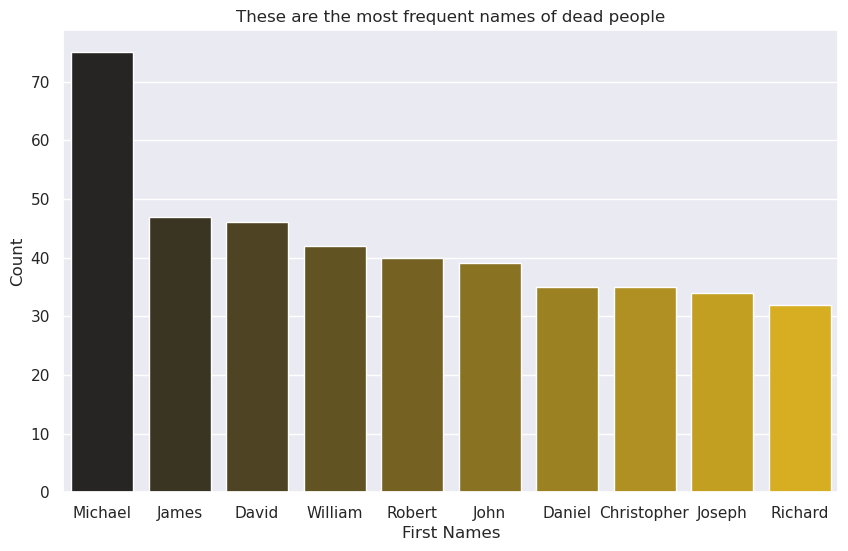

In [32]:
# These are the most frequent names of dead people using Barplot
plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
sns.barplot(x=top_first_names_df.index, y='Count', data=top_first_names_df, palette=sns.dark_palette("xkcd:golden", 10))
plt.title('These are the most frequent names of dead people')
plt.xlabel('First Names')
plt.ylabel('Count')
plt.show()

In [33]:
# Oldest and Youngest people died
top_10_oldest_people = df.nlargest(10,"Age").loc[:, ["Name", "Age"]].reset_index(drop=True)
top_10_youngest_people = df.nsmallest(10,"Age").loc[:, ["Name", "Age"]].reset_index(drop=True)

In [34]:
# Oldest
top_10_oldest_people

,Name,Age
0,Frank w. wratny,91
1,Raymond phillips,86
2,Eugene craig,86
3,Richard dale weaver,83
4,Quinton phillips,83
5,Darrel hetrick,82
6,Theodore brendecke,82
7,Edward acquisto,80
8,Robert becker,79
9,Douglas harris,77


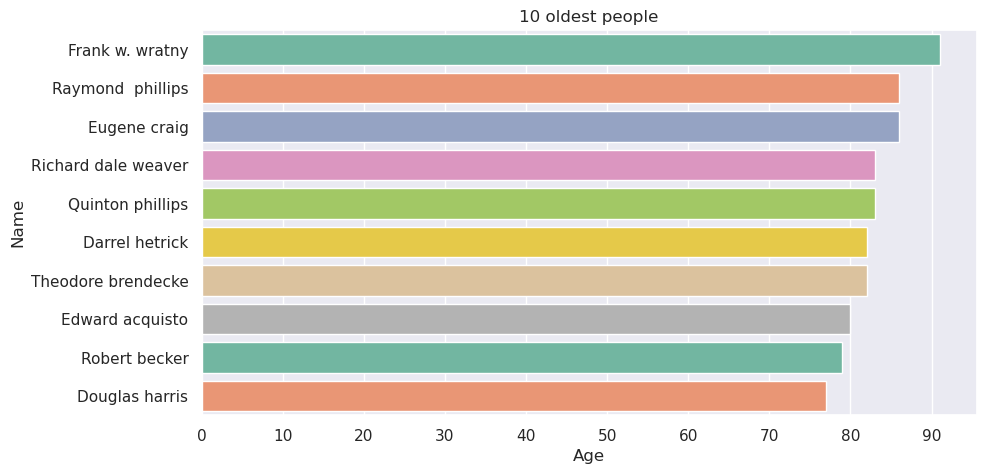

In [35]:
# Barplot of oldest people
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.barplot(data=top_10_oldest_people, x="Age", y="Name", palette="Set2")
plt.xticks(np.arange(0,100,10))
plt.title('10 oldest people')
plt.show(block=True)

In [36]:
# Youngest
top_10_youngest_people

,Name,Age
0,Jeremy mardis,6
1,Ciara meyer,12
2,Tyre king,13
3,Jesse james romero,14
4,Zane terryn,15
5,Andre green,15
6,Jorge santiago tapia,15
7,Jorevis scruggs,15
8,Luke smith,15
9,Daezion turner,15


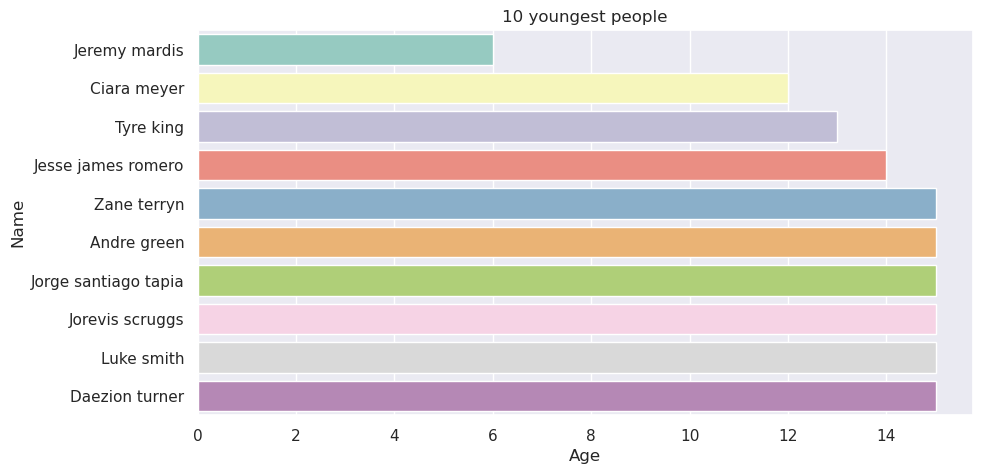

In [37]:
# Barplot of youngest people
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.barplot(data=top_10_youngest_people, x="Age", y="Name", palette="Set3")
plt.title('10 youngest people')
plt.show(block=True)

# Conclusion

On average, police in the United States shoot and kill more than 1,000 people every year. But it's hard to collect an accurate data as the police shootings are not properly documented.

Findings:
1. According to numbers white people killed the most. But we should consider majority of the population in US is White.
2. Killed people mostly armed with gun.
3. Men are killed the most.
4. Los Angeles is the city with the most cases and California is the most dangeorus state.
5. People between the ages of 25 and 45 are killed the most.
6. Michael is the most common names among the people killed.
